In [ ]:
!git clone https://github.com/mseaberg/lcls_beamline_toolbox #https://github.com/aashwinmishra/lcls_beamline_optimization

Cloning into 'lcls_beamline_toolbox'...
remote: Enumerating objects: 3287, done.
remote: Counting objects: 100% (558/558), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 3287 (delta 487), reused 427 (delta 365), pack-reused 2729
Receiving objects: 100% (3287/3287), 232.16 MiB | 25.07 MiB/s, done.
Resolving deltas: 100% (2537/2537), done.
Updating files: 100% (144/144), done.


In [ ]:
import os
os.chdir('lcls_beamline_toolbox')
!python3 -m pip install -e .
!pip install xraydb -q
!pip install pymoo -q

Obtaining file:///content/lcls_beamline_toolbox
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 32.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 59.3 MB/s eta 0:00:00
  Created wheel for xrt: filename=xrt-1.6.0-py3-none-any.whl size=5455911 sha256=d796e47d0b02875f38bf26cb753a4b0b39494f0f17da40353f5047bbcdeb3fd3
  Stored in directory: /root/.cache/pip/wheels/1c/47/52/d81d20e573b667bde10001744414b40202bef04daae4b2081d
Successfully built xrt
  Running setup.py develop for lcls-beamline-toolbox
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 M

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lcls_beamline_toolbox.xraywavetrace.beam1d as beam
import lcls_beamline_toolbox.xraywavetrace.optics1d as optics
import lcls_beamline_toolbox.xraywavetrace.beamline1d as beamline
import scipy.optimize as optimize
import copy
import scipy.spatial.transform as transform
from split_and_delay import SND

import torch


import warnings
warnings.filterwarnings("ignore")



from pymoo.core.problem import ElementwiseProblem

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.sms import SMSEMOA
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.termination import get_termination

from pymoo.optimize import minimize

from pymoo.indicators.hv import Hypervolume

In [ ]:
def get_snd_outputs(inputs):
  """
  Study 1 Objective function. Takes an [n, 8] dim np array of
  [samples, ( t1_th1, t1_th2, chi1, chi2, t4_th1, t4_th2, chi1, chi2)].
  The entries lie in the uniform unit interval.
  They are scaled to lie in [-100e-6, +100e-6].
  Returns a torch tensor of dim [n, 2] of
  [samples, (do_sum_objective, IP_r_objective)]
  """
  inputs = inputs*200e-6 - 100e-6
  inputs = inputs.reshape(1,-1)
  result = []

  for x in inputs:
    snd = SND(9500)
    x = np.array(x)

    snd.mvr_t1_th1(x[0])
    snd.mvr_t1_th2(x[1])
    snd.mvr_t1_chi1(x[2])#not in study 1
    snd.mvr_t1_chi2(x[3])#not in study 1
    snd.mvr_t4_th1(x[4])
    snd.mvr_t4_th2(x[5])
    snd.mvr_t4_chi1(x[6])#not in study 1
    snd.mvr_t4_chi2(x[7])#not in study 1

    # snd.mvr_t1_th1(x[0])
    # snd.mvr_t1_th2(x[1])
    # snd.mvr_t4_th1(x[2])
    # snd.mvr_t4_th2(x[3])

    snd.propagate_delay()

    dh1 = snd.get_t1_dh_sum()
    dd = snd.get_dd_sum()
    dh4 = snd.get_t4_dh_sum()
    do = snd.get_do_sum()
    my_IP_sum = snd.get_IP_sum()
    my_intensity = dh1 + dd + dh4 + do #+ my_IP_sum

    do_centroid = snd.get_IP_r()
    do_centroid_x = snd.get_IP_cx()
    do_centroid_y = snd.get_IP_cy()



    result.append([(my_intensity)/(60000.000), np.log(np.abs(do_centroid))/(-16.86781883239746)])
    del snd
  return np.array(result)

In [ ]:
class MyProblem(ElementwiseProblem):
  def __init__(self):
    super().__init__(n_var=8,
                      n_obj=2,
                      n_ieq_constr=0,
                      xl=np.zeros(8),
                      xu=np.ones(8))

  def _evaluate(self, x, out, *args, **kwargs):
    f1, f2 = get_snd_outputs(x).squeeze()

    out["F"] = [-f1, -f2]
    # out["G"] = [g1, g2]

In [ ]:
problem = MyProblem()

In [ ]:
# algorithm = NSGA2(pop_size=50)
#     # n_offsprings=,
#     # sampling=FloatRandomSampling(),
#     # crossover=SBX(prob=0.9, eta=15),
#     # mutation=PM(eta=20),
#     # eliminate_duplicates=True
# # )
algorithm = SMSEMOA(pop_size=25)

In [ ]:
termination = get_termination("n_gen", 20)

In [ ]:
res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       25 |      2 |             - |             -
     2 |       50 |      2 |  0.0826633195 |         ideal
     3 |       75 |      2 |  0.7399203002 |         ideal
     4 |      100 |      3 |  0.0619917753 |         ideal
     5 |      125 |      6 |  0.2242484900 |         ideal
     6 |      150 |      6 |  0.3328326219 |         ideal
     7 |      175 |      6 |  0.000000E+00 |             f
     8 |      200 |      4 |  0.5459046856 |         ideal
     9 |      225 |      5 |  0.0340789083 |             f
    10 |      250 |      7 |  0.0826178247 |         ideal
    11 |      275 |      6 |  0.1261861214 |         ideal
    12 |      300 |      6 |  0.5995540764 |         ideal
    13 |      325 |     10 |  0.0289561991 |         ideal
    14 |      350 |     11 |  0.0848974184 |         ideal
    15 |      375 |      1 |  0.0705831525 |         ideal
    16 |      400 |      1 |  0.000000E+00 |            

In [ ]:
X = res.X
F = res.F

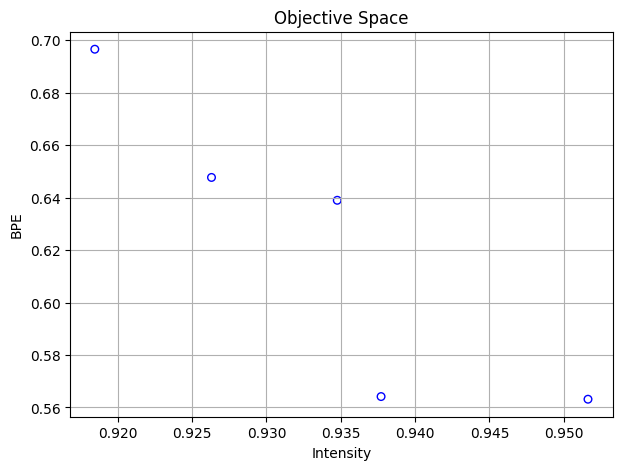

In [ ]:
plt.figure(figsize=(7, 5))
plt.scatter(-F[:, 0], -F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.xlabel("Intensity")
plt.ylabel("BPE")
plt.title("Objective Space")
plt.grid()
plt.show()

In [ ]:
from mpl_toolkits import mplot3d

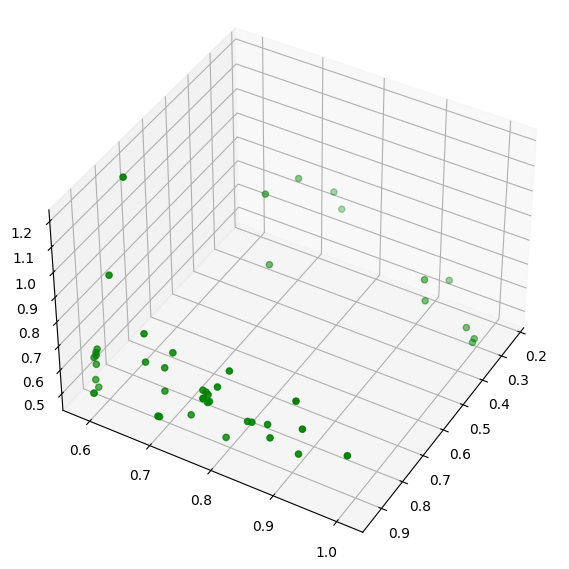

In [ ]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter3D(-F[:,0], -F[:,1], -F[:,2], color = "green")
ax.view_init(40,30)
plt.show()

In [ ]:
for x in X:
  out = get_snd_outputs(x)
  inten = out[0,0]*60000
  bpe = np.exp(-out[0,1]*16.86)
  print(inten, bpe)

56262.59641366907 7.39866385199299e-05
55578.18248516119 1.8097322037427676e-05
55107.2433642466 7.939155617978249e-06
57097.704703547395 7.526316182747502e-05
56085.79382436212 2.0959134888736306e-05
